# RNN for Engine Dataset

In [405]:
import torch
import numpy as np

In [406]:
train_file = np.loadtxt("../data/processed/processed_rnn_train_FD001.txt",delimiter=",",skiprows=1)
test_file  = np.loadtxt("../data/processed/processed_rnn_test_FD001.txt",delimiter=",",skiprows=1)
#,unit,RUL,os 1,os 2,os 3,sm 1,sm 2,sm 3,sm 4,sm 5,sm 6,sm 7,sm 8,sm 9,sm 10,sm 11,sm 12,sm 13,sm 14,sm 15,sm 16,sm 17,sm 18,sm 19,sm 20,sm 21
train_file = train_file[:,1:]
test_file = test_file[:,1:]


In [407]:
print(train_file.shape)

(20631, 26)


In [415]:
import random

# convert time series data for 1 unit to tensor along with RUL (always 0)
def getUnitData(data,i):
    ind = np.where(data[:,0] == i)
    ind = ind[0]
    num_lines = ind.size
    num_features = data.shape[1] - 2
    data_tensor = torch.zeros(num_lines,1,num_features)
    last_ind = ind[-1]
    for t in range(num_lines):
        for i in range(num_features):
            data_tensor[t][0][i] = float(data[ind[t],2+i])
    rul_tensor = torch.tensor(data[last_ind,1],dtype=torch.float)

    return data_tensor,rul_tensor

# subsample a section of a unit data so not all training targets are 0
def sampleData(data,maxUnits):
    unit_num = random.randint(1,maxUnits)
    data,rul = getUnitData(data,unit_num)
    last_step = data.size()[0]

    # minimum size for training series
    min_steps = 15
    max_steps = 100

    #select random starting index and length for training example
    start = random.randint(0,max_steps-min_steps)
    length = random.randint(min_steps,max_steps)
    end = min(start+length,last_step)
    length = start - end

    data = data[start:end]
    rul = torch.tensor([[rul.item() + last_step - end - 1]])

    return data,rul


In [416]:
# print(getUnitData(train_file,1)[1])
print(sampleData(train_file,100)[1])

tensor([[46.]])


## Design Network

In [417]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_features = 24
n_hidden = 256
n_output = 1
rnn = RNN(n_features, n_hidden, n_output)

loss_fn = nn.MSELoss()
learning_rate = 5e-12

In [418]:
def train(data,target):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for t in range(data.size()[0]):
        output,hidden = rnn(data[t],hidden)
    
    loss = loss_fn(output,target)
    loss.backward()

    # Adjust parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)

    return output,loss.item()

In [419]:
maxUnits = int(np.max(train_file[:,0]))

input,rul = getUnitData(train_file,1)
print(input[0].size())

hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[1], hidden)
print(output)

torch.Size([1, 24])
tensor([[-409.7996]], grad_fn=<AddmmBackward0>)


## Training

In [423]:
import time
import math

n_iters = 1000
print_every = 100
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    data,rul = sampleData(train_file,maxUnits)
    output, loss = train(data,rul)

    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        # guess, guess_i = categoryFromOutput(output)
        # correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d%% (%s) %.4f' % (iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10% (0m 2s) 118961.2891
20% (0m 5s) 67401.0547
30% (0m 8s) 39870.4805
40% (0m 11s) 7595.6973
50% (0m 14s) 3450.3645
60% (0m 17s) 2084.1194
70% (0m 20s) 3425.2031
80% (0m 23s) 1345.9430
90% (0m 26s) 737.3836
100% (0m 29s) 8198.9814


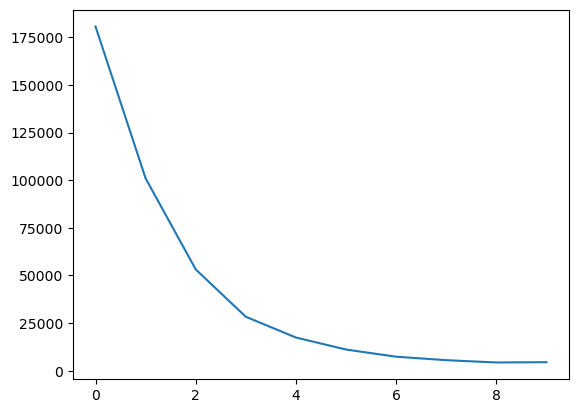

In [424]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
# plt.ylim([0,5000])

## Testing Model Performance

In [434]:
def evaluate(input):
    with torch.no_grad():
        hidden = rnn.initHidden()

        for t in range(input.size()[0]):
            output,hidden = rnn(input[t],hidden)
    
    return output

def predict(input):
    output = evaluate(input)

    return output

In [459]:
n_train = 100
error = np.zeros((n_train,1))
for i in range(n_train):
    data,rul = sampleData(train_file,maxUnits)
    pred = predict(data)
    error[i] = (pred - rul).item()

(array([ 1.,  0.,  5.,  3., 11., 14., 23., 19., 14., 10.]),
 array([-222.46578979, -191.2569725 , -160.04815521, -128.83933792,
         -97.63052063,  -66.42170334,  -35.21288605,   -4.00406876,
          27.20474854,   58.41356583,   89.62238312]),
 <BarContainer object of 10 artists>)

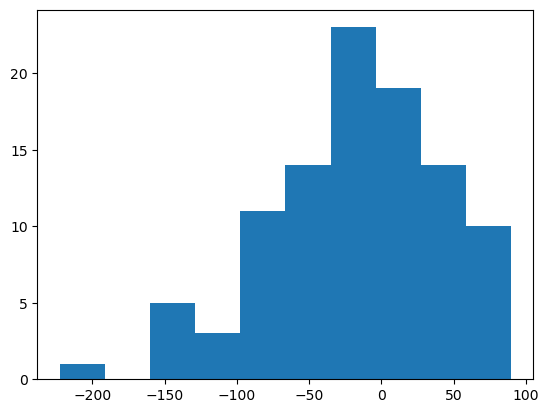

In [460]:
plt.hist(error)